# Using the BigQuery Cloud Resource (ISB-CGC)

![bird1](https://www.sciencemag.org/sites/default/files/styles/inline__699w__no_aspect/public/bird_16x9.jpg?itok=H7yn8bXq)

from: https://www.sciencemag.org/news/2018/04/bigger-better-bird-tree-life-will-soon-fly-view

**Workspace**:

1. BigQuery Web Interface: https://console.cloud.google.com/bigquery

2. Jupyter notebook: https://colab.research.google.com  (could be local, Google colab, datalab, or GC jupyter lab)

3. Documentation: https://cloud.google.com/bigquery/docs/reference/standard-sql/




---


**Finding ISB-CGC BigQuery tables.**

0. A google search for 'ISB-CGC TCGA BigQuery' finds our [documentation]( https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/data/data2/data_in_BQ.html).

1.  Bioconductor R package BiocOncoTK points to *our* tables.  https://rdrr.io/bioc/BiocOncoTK/src/R/pancan.R

2. At the GDC:  https://gdc.cancer.gov/about-data/publications/PanCan-Clinical-2018 



---



**Goal:**

Compare single cell RNA-Seq to TCGA expression data.

Stretch goal: What compares better?  The bulk or a summarized single cell profile?

---



Downloaded data from GEO:  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75688

Paper: https://www.ncbi.nlm.nih.gov/pubmed/28474673

Tranformed using the melt function in 'reshape2', and used the web interface to load the table
into a new data set.

![alt text](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5424158/bin/ncomms15081-f1.jpg)



Then we have 2 new  tables, 

one containing scRNA-seq values: isb-cgc-02-0001:brca_single_cell_RNA.gse75688_sc_brca

and another containing info about each cell: isb-cgc-02-0001:brca_single_cell_RNA.gse75688_sample_info



---



Now we get setup for running some queries!

# SETUP

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
  

In [0]:
from google.colab import auth
from google.cloud import bigquery

def cgcAuth(project):
  try:
    auth.authenticate_user()
    print('You have been successfully authenticated!')
  except:
    print('You have not been authenticated.')
  
  try:
    project_id = 'isb-cgc-02-0001'
    bqclient = bigquery.Client(project=project_id)
    print('BigQuery client successfully initialized')
  except:
    print('Failure to initialize BigQuery client')
  
  return(bqclient)



def runQuery ( client, qString, dryRun=False ):
  
  print ( "\n in runQuery ... " )
  if ( dryRun ):
    print ( "    dry-run only " )
    
  ## set up QueryJobConfig object
  job_config = bigquery.QueryJobConfig()
  job_config.dry_run = dryRun
  job_config.use_query_cache = True
  job_config.use_legacy_sql = False
  
  ## run the query
  try:
    query_job = client.query ( qString, job_config=job_config )
    ## print ( "    query job state: ", query_job.state )
  except:
    print ( "  FATAL ERROR: query execution failed " )
    return ( None )
  
  ## return results as a dataframe (or an empty dataframe for a dry-run) 
  if ( not dryRun ):
    try:
      df = query_job.to_dataframe()
      if ( query_job.total_bytes_processed==0 ):
        print ( "    the results for this query were previously cached " )
      else:
        print ( "    this query processed {} bytes ".format(query_job.total_bytes_processed) )
      if ( len(df) < 1 ):
        print ( "  WARNING: this query returned NO results ")
      return ( df )
    except:
      print ( "  FATAL ERROR: query execution failed " )
      return ( None )
    
  else:
    print ( "    if not cached, this query will process {} bytes ".format(query_job.total_bytes_processed) )
    ## return an empty dataframe
    return ( pd.DataFrame() )
 


def checkQueryResults ( qr ):
  print ( "\n in checkQueryResults ... " )
  if ( not isinstance(qr, pd.DataFrame) ):
    print ( " query execution failed! " )
    return ( False )
  else:
    if ( len(qr) > 0 ): 
      print ( " # of rows in query results: {} ".format(len(qr)) )
      print ( "\n", qr.head() )
    else:
      print ( " query returned NO results ?!? " )  
    return ( True )

In [0]:
# Start by getting authorized.

bqclient = cgcAuth( project='isb-cgc-02-0001' )

You have been successfully authenticated!
BigQuery client successfully initialized


#BigQueries!#

In [0]:
# Sample counts, by single cell vs bulk

sql = '''
SELECT
   COUNT(Sample) AS n,
   Type
FROM 
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info` 
GROUP BY
   Type
'''

res0 = runQuery ( bqclient, sql, dryRun=False )

res0


 in runQuery ... 
    the results for this query were previously cached 


,n,Type
0,515,SC
1,13,Bulk


We have 515 single cell RNA profiles, and 13 Bulk RNA profiles.

In [0]:
# Sample count, by type, source, kind

sql = '''
SELECT
   COUNT(Sample) AS n,
   Type,
   index1,
   index2
FROM 
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info` 
GROUP BY
   2,3,4
'''

res0 = runQuery ( bqclient, sql, dryRun=False )

res0


 in runQuery ... 
    the results for this query were previously cached 


,n,Type,index1,index2
0,175,SC,nonTumor,Immune
1,4,Bulk,nonTumor,Immune
2,23,SC,nonTumor,Stromal
3,317,SC,Tumor,Tumor
4,9,Bulk,Tumor,Tumor


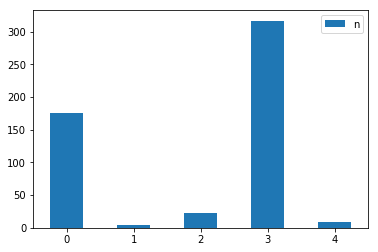

In [0]:
res0.plot.bar(rot=0)


 in runQuery ... 
    the results for this query were previously cached 


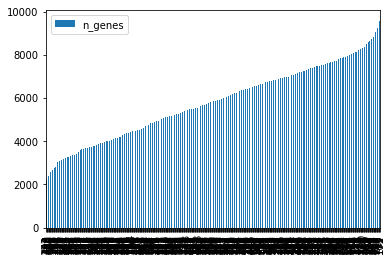

In [0]:
# How many genes were measured in each cell?

sql = '''
WITH

-- create a 'cohort' of cells
--

sc_info AS (
SELECT
   sample
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info` 
WHERE
   type = 'SC'
GROUP BY
   sample
),

--
--  
--

sc_values AS (
SELECT
   COUNT(gene_name) AS n_genes,
   sample_name
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sc_brca`
WHERE
   sample_name IN (
      SELECT sample from sc_info
      )
   AND value > 0
GROUP BY 
   sample_name
   )

select * from sc_values

'''

geneCount = runQuery ( bqclient, sql, dryRun=False )

geneCount.sort_values('n_genes').plot.bar()

So we see that cells have between 2000 to close to 10K genes measured. That's a good data set.  But how many of them are mitochondrial genes?

In [0]:
# What kind of genes do we have?

sql = '''
WITH

-- create a cohort

sc_info AS (
SELECT
   sample
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info` 
WHERE
   type = 'SC'
GROUP BY
   sample
),

sc_values AS (
SELECT
   COUNT(DISTINCT(gene_name)) as n_genes,
   gene_type
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sc_brca`
WHERE
   sample_name IN (
      SELECT sample from sc_info
      )
   AND value > 0
GROUP BY 
   2
   )

select * from sc_values
'''

geneTypeCount = runQuery ( bqclient, sql, dryRun=False )
geneTypeCount




 in runQuery ... 
    the results for this query were previously cached 


,n_genes,gene_type
0,3863,antisense
1,6759,pseudogene
2,18384,protein_coding
3,3825,lincRNA
4,557,sense_intronic
5,5,TR_C_gene
6,451,misc_RNA
7,423,processed_transcript
8,105,IG_V_gene
9,156,sense_overlapping


Now, to start building towards correlating sc profiles with TCGA samples...

In [0]:
sql = '''

WITH

-- create a cohort

sc_info AS (
SELECT
   sample
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info` 
WHERE
   type = 'SC'
   AND NOT REGEXP_CONTAINS(sample, 'LN_')
   AND NOT REGEXP_CONTAINS(sample, 'Re_')
GROUP BY
   sample
),

-- and collect the expression values, removing lymph node and metastise

sc_values AS (
SELECT
   sample_name,
   gene_name,
   value
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sc_brca`
WHERE
   sample_name IN (
      SELECT sample from sc_info
      )
   AND value > 0
   AND gene_type = 'protein_coding'
GROUP BY 
   1,2,3
   )

select * from sc_values

'''

scValues = runQuery ( bqclient, sql, dryRun=False )

scValues[0:5]


 in runQuery ... 
    this query processed 1325123882 bytes 


,sample_name,gene_name,value
0,BC05_93,PTPRF,71.34
1,BC05_83,SPTLC1,60.70
2,BC04_92,PHF11,24.27
3,BC07_43,PRPF40A,290.11
4,BC02_10,PLP2,167.39


In [0]:

# Now we'll build a table that joins single cell RNA-seq to TCGA RNA-seq data.

sql = '''

WITH

-- create a cohort

sc_info AS (
SELECT
   sample
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info` 
WHERE
   type = 'SC'
   AND index1 = 'Tumor'
   AND NOT REGEXP_CONTAINS(sample, 'LN_')
GROUP BY
   sample
),

sc_values AS (
SELECT
   sample_name,
   gene_name,
   value
FROM
   `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sc_brca`
WHERE
   sample_name IN (
      SELECT sample from sc_info
      )
   AND value > 0
   AND gene_type = 'protein_coding'
GROUP BY 
   1,2,3
),

tcga_join AS (
SELECT
   tcga.project_short_name as short_name,
   tcga.sample_barcode as sample_barcode,
   tcga.gene_name as tcga_gene_name,
   tcga.HTSeq__FPKM_UQ,
   RANK() OVER(PARTITION BY sample_barcode, sample_name ORDER BY HTSeq__FPKM_UQ) as tcga_rank_FPKM,
   sc.sample_name as cell_id,
   sc.gene_name as sc_gene_name,
   sc.value as value,
   RANK() OVER(PARTITION BY sample_barcode, sample_name ORDER BY value) as sc_rank_value
FROM
   `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression` AS tcga
JOIN
    sc_values AS sc
ON
   sc.gene_name = tcga.gene_name
WHERE
   tcga.project_short_name = 'TCGA-BRCA'
GROUP BY
   1,2,3,4,6,7,8
)

select * from tcga_join 


'''

dontRun = runQuery ( bqclient, sql, dryRun=False )


### This query was saved in a new BQ table ###
### TO do this, we can use the query settings in the web interface ###




Now we have a table of sc-brca values and we can correlate on that (or cosine similarity!).


 in runQuery ... 
    this query processed 81844354698 bytes 


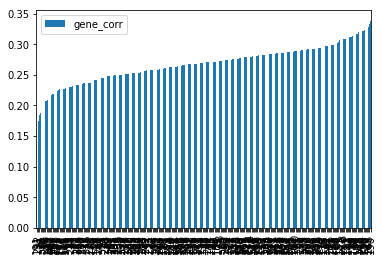

In [0]:


## One TCGA sample correlated with single cells ##

sql = '''
SELECT
  sample_barcode,
  cell_id,
  CORR( tcga_rank_FPKM, sc_rank_value) as gene_corr
FROM
  `isb-cgc-02-0001.brca_single_cell_RNA.brca_sc_join`
WHERE
  sample_barcode = 'TCGA-3C-AAAU-01A'
GROUP BY
  1,2
'''

corrValues = runQuery ( bqclient, sql, dryRun=False )

corrValues.sort_values('gene_corr').plot.bar()



In [0]:
## One TCGA-BRCA sample correlated with single cells ##

sql = '''
SELECT
  sample_barcode,
  cell_id,
  tcga_rank_FPKM, 
  sc_rank_value
FROM
  `isb-cgc-02-0001.brca_single_cell_RNA.brca_sc_join`
WHERE
  sample_barcode = 'TCGA-3C-AAAU-01A'
GROUP BY
  1,2,3,4
'''

joinedBrcaValues = runQuery ( bqclient, sql, dryRun=False )



 in runQuery ... 
    this query processed 81844354698 bytes 


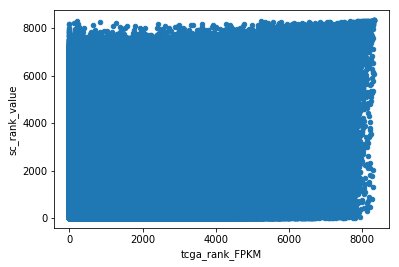

In [0]:
joinedBrcaValues.plot.scatter(x='tcga_rank_FPKM', y='sc_rank_value')

This was repeated for KIRC, producing two tables.
The BRCA-sc table has 1 billion rows and took about a minute to make.
The KIRC-sc table has (only) 900 Mil rows and takes 60GB.

In [0]:

## Summarizing all TCGA-BRCA samples correlated with single cells ##

sql = '''

WITH brca_corrs AS (
SELECT
  sample_barcode,
  cell_id,
  CORR( tcga_rank_FPKM, sc_rank_value) as gene_corr
FROM
  `isb-cgc-02-0001.brca_single_cell_RNA.brca_sc_join`
GROUP BY
  1,2
)

SELECT
  gene_corr
FROM
  brca_corrs
  
'''

brca_avg_corr = runQuery ( bqclient, sql, dryRun=False )

brca_avg_corr.describe()



 in runQuery ... 
    this query processed 81844354698 bytes 


,gene_corr
count,341977.000000
mean,0.298563
std,0.037950
min,0.041164
25%,0.275479
50%,0.301287
75%,0.324592
max,0.440421



 in runQuery ... 
    this query processed 40919300348 bytes 


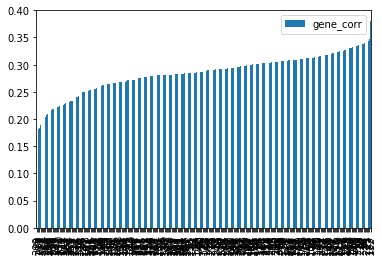

In [0]:

## One TCGA-KIRC sample correlated with single cells ##

sql = '''
SELECT
  sample_barcode,
  cell_id,
  CORR( Rank_FPKM, sc_rank_value ) as gene_corr
FROM
  `isb-cgc-02-0001.brca_single_cell_RNA.kirc_sc_join`
WHERE
  sample_barcode = 'TCGA-A3-3307-01A'
GROUP BY
  1,2
'''

corrValues = runQuery ( bqclient, sql, dryRun=False )

corrValues.sort_values('gene_corr').plot.bar()


In [0]:
## One TCGA-KIRC sample correlated with single cells ##

sql = '''
SELECT
  sample_barcode,
  cell_id,
  Rank_FPKM, 
  sc_rank_value
FROM
  `isb-cgc-02-0001.brca_single_cell_RNA.kirc_sc_join`
WHERE
  sample_barcode = 'TCGA-A3-3307-01A'
GROUP BY
  1,2,3,4
'''

joinedValues = runQuery ( bqclient, sql, dryRun=False )

joinedValues[0:5]

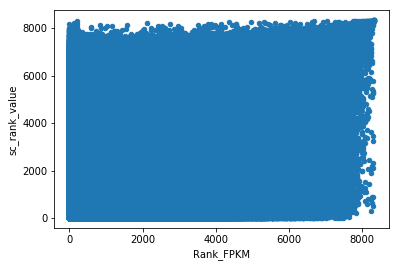

In [0]:
joinedValues.plot.scatter(x='Rank_FPKM', y='sc_rank_value')

In [0]:
## All TCGA-KIRC samples correlated with single cells ##

sql = '''

WITH kirc_corrs AS (
SELECT
  sample_barcode,
  cell_id,
  CORR(  Rank_FPKM, sc_rank_value ) as gene_corr
FROM
  `isb-cgc-02-0001.brca_single_cell_RNA.kirc_sc_join`
GROUP BY
  1,2
)

SELECT
  gene_corr
FROM
  kirc_corrs
'''

kirc_avg_corr = runQuery ( bqclient, sql, dryRun=False )

kirc_avg_corr.describe()



 in runQuery ... 
    this query processed 40919300348 bytes 


,gene_corr
count,170567.000000
mean,0.276503
std,0.036234
min,0.018546
25%,0.256678
50%,0.279593
75%,0.300494
max,0.434058


So, BRCA is slightly more correlated to single cells, compared to KIRC samples.

It might be better to either take the top correlating genes in BRCA, and use those genes
in comparing other tissues... Or just take high expression genes in the single cells, and 
just use those.

In [0]:

### Here's an example of when things don't go as expected!
# This query takes forever forever.

sql = '''


WITH
  sc_info AS (
  SELECT
    sample
  FROM
    `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info`
  WHERE
    type = 'SC'
    AND index1 = 'Tumor'
    AND NOT REGEXP_CONTAINS(sample, 'LN_')
  GROUP BY
    sample ),
    --
    --
  summed_sc AS (
  SELECT
    gene_name,
    sample_name,
    SUM(value) AS summed_value
  FROM
    `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sc_brca`
  WHERE
    sample_name IN (
    SELECT
      sample
    FROM
      sc_info )
    AND value > 0
    AND gene_type = 'protein_coding'
  GROUP BY
    1,
    2 ),
  tcga_join AS (
  SELECT
    tcga.project_short_name AS short_name,
    tcga.sample_barcode AS sample_barcode,
    tcga.gene_name AS tcga_gene_name,
    tcga.HTSeq__FPKM_UQ,
    RANK() OVER(PARTITION BY sample_barcode, sample_name ORDER BY HTSeq__FPKM_UQ) AS tcga_rank_FPKM,
    sc.sample_name AS cell_id,
    sc.gene_name AS sc_gene_name,
    sc.summed_value AS summed_value,
    RANK() OVER(PARTITION BY sample_barcode, sample_name ORDER BY summed_value) AS sc_rank_sum
  FROM
    `isb-cgc.TCGA_hg38_data_v0.RNAseq_Gene_Expression` AS tcga
  JOIN
    summed_sc AS sc
  ON
    sc.gene_name = tcga.gene_name
  WHERE
    tcga.project_short_name = 'TCGA-BRCA'   -- change tissue types here
  GROUP BY
    1,
    2,
    3,
    4,
    6,
    7,
    8 ),
  corrTable AS (
  SELECT
    sample_barcode,
    cell_id,
    CORR( tcga_rank_FPKM,
      sc_rank_sum) AS gene_corr
  FROM
    tcga_join
  GROUP BY
    1,
    2 )
  --
  --
SELECT
  AVG(gene_corr) avg_corr,
  VAR_SAMP(gene_corr) corr_var
FROM
  corrTable
  
  '''

brca_summed_corr = runQuery ( bqclient, sql, dryRun=False )

brca_summed_corr.describe()
  
# 1	BRCA
# mean corr 0.298
# var  corr 0.001

# 1	KIRC
# 0.276
# 0.001



So we've tried correlating individual cells with TCGA samples, and even summing across cells before
correlation, and we've found that the matching tissue has a very small bit larger correlation.

Probably need to focus on particular genes first...

In [0]:
sql = '''
WITH
  -- create a cohort
    --
    --
    --
sc_info AS (
  SELECT
    sample,
    index1,
    index2,
    index3
  FROM
    `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sample_info`
  WHERE
    type = 'SC'
  GROUP BY
    sample,
    index1,
    index2,
    index3),
    --
    --
    --
  sc_values AS (
  SELECT
    sample_name,
    index1,
    index2,
    index3,
    gene_name,
    gene_type,
    value,
    RANK() OVER(PARTITION BY sample_name ORDER BY value) AS rank_value
  FROM
    `isb-cgc-02-0001.brca_single_cell_RNA.gse75688_sc_brca`
  JOIN
    sc_info
  ON
    sc_info.sample = sample_name
  WHERE
    value > 0
    AND gene_type = 'protein_coding'
  GROUP BY
    1,
    2,
    3,
    4,
    5,
    6,
    7 
    ),
    --
    --
    --
sc_join AS (
  SELECT
    sc1.sample_name AS cell_id1,
    sc1.index1 AS sc_index11,
    sc1.index2 AS sc_index12,
    sc1.index3 AS sc_index13,    
    sc1.gene_name AS sc_gene_name1,
    sc1.gene_type AS sc_gene_type1,
    sc1.value AS value1,
    sc1.rank_value as sc1_rank,
    sc2.sample_name AS cell_id2,
    sc2.index1 AS sc_index21,
    sc2.index2 AS sc_index22,
    sc2.index3 AS sc_index23,
    sc2.gene_name AS sc_gene_name2,
    sc2.gene_type AS sc_gene_type2,
    sc2.value AS value2,
    sc2.rank_value as sc2_rank
  FROM
    sc_values AS sc1
  JOIN
    sc_values AS sc2
  ON
    sc1.gene_name = sc2.gene_name
    AND sc1.sample_name > sc2.sample_name
  GROUP BY
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16)
    
    --
    --
    --
SELECT
  sc_index12,
  sc_index13,
  sc_index22,
  sc_index23,
  CORR(sc1_rank,
    sc2_rank) corr
FROM
  sc_join
GROUP BY
  1,
  2,
  3,
  4
ORDER BY 
  corr DESC
'''

runQuery ( bqclient, sql, dryRun=False )


 in runQuery ... 
    this query processed 1325135927 bytes 


,sc_index12,sc_index13,sc_index22,sc_index23,corr
0,Tumor,Tumor,Tumor,Tumor,0.287939
1,Immune,Myeloid,Immune,Myeloid,0.267972
2,Tumor,Tumor,Immune,Myeloid,0.267548
3,Immune,Bcell,Immune,Myeloid,0.247840
4,Immune,Tcell,Immune,Myeloid,0.239118
5,Immune,Bcell,Immune,Bcell,0.239003
6,Tumor,Tumor,Immune,Tcell,0.227267
7,Tumor,Tumor,Immune,Bcell,0.226611
8,Immune,Myeloid,Tumor,Tumor,0.225625
9,Stromal,Stromal,Tumor,Tumor,0.224335
